In [270]:
import numpy as np
import pandas as pd
import scipy
import random
from scipy.stats import multivariate_normal
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm, trange
import time # to be used in loop iterations
np.random.seed(1234)

## Single-digit neural single layer network trained on the MNIST dataset

I implemented a neural single layer network with symmetric architecture trained on the MNIST dataset that performs single digit architecture and tried to study the asymptotic distribution of network parameters as claimed in the 2019 paper by Sirgiano and Spiliopoulos entitled 'Mean Field Analysis of Neural Networks: A Law of Large Numbers'.

In [271]:
def sigmoid(x):
    if x < 0:
        return np.exp(x)/(1+np.exp(x))
    else:
        return 1/(1+np.exp(-x))
vsigmoid = np.vectorize(sigmoid)   

In [272]:
#standardising dataset
def standardise_mlp(X):
    """
    Args:

    X: numpy array of shape (n_samples, n_features) representing the input data

    Returns:

    Xbar: numpy array of shape (n_samples, n_features) representing the standardized input data
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xstd = ((X-mu)/std_filled)
    return Xstd

In [273]:
# Load training data 

#train data
data = pd.read_csv('MNIST_train.csv')

#training set ground truth labels
y_train = np.squeeze(np.array(data[data.columns[0]]))

train_data = data[data.columns[1:]].to_numpy()

#standardise train data
train_data_std = standardise_mlp(train_data)

#test data
test_data = pd.read_csv('MNIST_test.csv')

#test set ground truth labels
y_test = np.array(test_data[test_data.columns[0]])

test_data = test_data[test_data.columns[1:]].to_numpy()

#standardise test data
test_data_std = standardise_mlp(test_data)


x_train = train_data_std
y_train = np.where(y_train == 0,  1, -1)
x_test = test_data_std
y_test = np.where(y_test == 0,  1, -1)

In [274]:
def neural_net(x,w,c):
    """
    Compute the output of a neural network with given weights and coefficients.

    Parameters:
    x (np.ndarray): Input data with shape (n, d).
    w (np.ndarray): Weight matrix with shape (N, d).
    c (np.ndarray): Coefficients of the neural network with shape (1, N).

    Returns:
    np.ndarray: The output of the neural network with shape (1, n).
    """
    n = x.shape[0]
    d = x.shape[1]
    N = w.shape[0]
    return (1/N*c@vsigmoid(w@x.T)).reshape(1,n)

In [281]:
def train(x_train, y_train, x_test, y_test, Epochs = 1e6, N = 100, learning_rate = 1e-2):
    """
    Train a neural network with a specified number of units (N) using stochastic gradient descent.

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    learning_rate (float): The learning rate for stochastic gradient descent (default is 1e-2).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and a list of loss values during training.
    """
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    params = 0
    #sgd - update weights (using KL loss)
    epoch = 1
    
    while epoch < Epochs:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
        
        for x,y in tqdm(zip(x_train,y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            f = neural_net(x,w,c).reshape(1,-1)
            s = vsigmoid(w@x.T)
            dw = 1/N * ((f-y)@c).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)
            w -= learning_rate*dw
            c -= learning_rate*dc

            if  epoch in [1, 10 , 100] + list((10**np.linspace(3, 6, 30)).astype(int)): 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            epoch += 1 
    params = np.linalg.norm(np.hstack((c.T, w)), axis = 1).reshape(N,1)
    return c, w, params, losses

In [276]:
def nesterov_train(x_train, y_train, x_test, y_test, N = 100, r = 3, learning_rate = 1e-2):
    """
    Train a neural network with a specified number of units (N) using Nesterov's accelerated gradient descent.

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    r (int): The number of steps for Nesterov's acceleration (default is 3).
    learning_rate (float): The learning rate for Nesterov's SGD (default is 1e-2).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and a list of loss values during training.
    """
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    w_change = w
    c_change = c
    
    epoch = 1
    while epoch < 1e6:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
    
        for x,y in tqdm(zip(x_train,y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            f = neural_net(x,w_change,c_change).reshape(1,-1)
            s = vsigmoid(w_change@x.T)
            dw = 1/N * ((f-y)@c_change).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)
            w1 = w
            c1 = c

            if  epoch in [1, 10 , 100] + list((10**np.linspace(3, 6, 30)).astype(int)): 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            w_new = w_change - learning_rate*dw
            c_new = c_change - learning_rate*dc
            w_change = w_new + 0.9*(w_new-w1) 
            c_change = c_new + 0.9*(c_new-c1) 
            w = w_new
            c = c_new

            epoch += 1
        
    return c, w, np.ndarray.flatten(c), losses

In [277]:
def Hom_SGLD(x_train, y_train, x_test, y_test, indices_hom, N = 100,  M = 20, λ = 10, learning_rate = 1e-3):
    """
    Train a neural network with a specified number of units (N) using Hamiltonian SGLD (Hom-SGLD).

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    M (int): The number of Hamiltonian SGLD steps (default is 20).
    λ (float): The regularization parameter (default is 10).
    learning_rate (float): The learning rate for Hom-SGLD (default is 1e-3).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and an array of loss values during training.
    """

    #initialise Params
    d = x_train.shape[1]
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((M+1, N, d))
    Y_c = np.zeros((M+1, N))
    
    losses = []
    
    epoch = 1
    while epoch < 1e6:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
    
        for x,y in tqdm(zip(x_train,y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)

            #update Y
            Y_w_1 = np.zeros((M+1, N, d))
            Y_c_1 = np.zeros((M+1, N))
            Y_w_1[0, :, :] = Y_w[-1, :, :] 
            Y_c_1[0, :] = Y_c[-1, :]

            for m in range(1,M+1):
                δ = 0.01/20
                γ = 0.1
                β = 10
                f = neural_net(x, Y_w_1[m-1, :, :].reshape((N,d)),  Y_c_1[m-1, :].reshape((1,N)))
                s = vsigmoid(Y_w_1[m-1, :, :].reshape((N,d))@x.T)
                dw = 1/N * ((f-y)@Y_c_1[m-1,:].reshape(1,N)).T*(s*(1-s))*x
                dc = 1/N * (f-y).T*s.reshape(1,-1)

                Y_w_1[m, :,:] = Y_w_1[m-1, : ,:] - δ*(dw-(1/γ)*(w-Y_w_1[m-1, :, :]))\
                + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
                Y_c_1[m, :] = Y_c_1[m-1,:] - δ*(dc-(1/γ)*(c-Y_c_1[m-1, :]))\
                + np.sqrt(2*(δ/β))*np.random.normal(0,1,N)

            Y_w[0, :, :] = Y_w_1[-1, :, :]
            Y_c[0, :] = Y_c_1[-1, :]


            cal_Y_w = np.mean(Y_w_1, axis = 0)
            cal_Y_c = np.mean(Y_c_1, axis = 0)


            #update model parameters
            Δ = learning_rate
            X = np.hstack((w, c.T))
            mu = np.mean(X, axis = 1).reshape(1,N)
            w = w - 1/γ*(w-cal_Y_w)*Δ - λ*(w - mu.T)*Δ
            c = c - 1/γ*(c-cal_Y_c)*Δ - λ*(c - mu)*Δ

            if  epoch in indices_hom: 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            epoch +=1
                
    return c, w, np.ndarray.flatten(c), np.array(losses)

In [278]:
def Mass(x_train, y_train, x_test, y_test, Epochs = 1e6, N = 100,  M = 20, λ = 10, learning_rate = 1e-3):
    """
    Train a neural network with a specified number of units (N) using Momentum-added Stochastic Solver (Mass).

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    M (int): The number of Mass steps (default is 20).
    λ (float): The regularization parameter (default is 10).
    learning_rate (float): The learning rate for Mass (default is 1e-3).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w',
           and an array of loss values during training.
    """

    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    w_change = w
    c_change = c
    
    epoch = 1
    count = 1
    
    while epoch < Epochs:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
        
        for x,y in tqdm(zip(x_train, y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            f = neural_net(x,w_change,c_change).reshape(1,-1)
            s = vsigmoid(w_change@x.T)
            dw = 1/N * ((f-y)@c_change).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)
            w1 = w
            c1 = c

            m = 2
            eta2 = learning_rate/m

            w_new = w_change - learning_rate*dw
            c_new = c_change - learning_rate*dc
            w_change = w_new + (count-1)/(count+2)*(w_new-w1) + eta2*dw
            c_change = c_new + (count-1)/(count+2)*(c_new-c1) + eta2*dc
            w = w_new
            c = c_new
            
            if (dc@(c_new-c).T)[0]+(dw*(w_new-w)).sum()>0:
                count =1

            if  epoch in [1, 10, 100] + list((10**np.linspace(3, 6, 30)).astype(int)): 
                f_test = neural_net(x_test,w,c).reshape(-1,1)
                y_test = y_test.reshape(-1,1)
                loss = 0.5*np.mean((f_test-y_test)**2)
                print('Epoch count: {}, Loss: {}'.format(epoch, loss))
                losses.append(loss)

            epoch +=1
            count+=1
                
    return c, w, np.array(losses)

In [279]:
c, w, risk_Mass = Mass(x_train, y_train, x_test, y_test, N = 10, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 7348.41488300497
Epoch count: 10, Loss: 10984.425617472152
Epoch count: 100, Loss: 8552.789251843338
Epoch count: 1000, Loss: 2829.188207375442
Epoch count: 1268, Loss: 2773.2695751049646
Epoch count: 1610, Loss: 1991.5102627062242
Epoch count: 2043, Loss: 1252.7094851962065
Epoch count: 2592, Loss: 858.1978984335182
Epoch count: 3290, Loss: 422.02105118270083
Epoch count: 4175, Loss: 116.4816661382183
Epoch count: 5298, Loss: 37.00169839615311
Epoch count: 6723, Loss: 43.260322193220105
Epoch count: 8531, Loss: 12.17827306785274
Epoch count: 10826, Loss: 11.825992992554713
Epoch count: 13738, Loss: 3.694746862423015
Epoch count: 17433, Loss: 2.7120028411569237
Epoch count: 22122, Loss: 0.7015732583228752
Epoch count: 28072, Loss: 0.6908879205721448
Epoch count: 35622, Loss: 0.2837497964602033
Epoch count: 45203, Loss: 0.21968823651214658
Epoch count: 57361, Loss: 0.24167803622089581


0it [00:00, ?it/s]

Epoch count: 72789, Loss: 0.2654496574234852
Epoch count: 92367, Loss: 0.24045683082178668
Epoch count: 117210, Loss: 0.23209097474724863


0it [00:00, ?it/s]

Epoch count: 148735, Loss: 0.20186066196362307


0it [00:00, ?it/s]

Epoch count: 188739, Loss: 0.2681225626265872
Epoch count: 239502, Loss: 0.21196745443360113


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 303919, Loss: 0.1740520419053272


0it [00:00, ?it/s]

Epoch count: 385662, Loss: 0.22426214450695806


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 489390, Loss: 0.42713000586597305


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 621016, Loss: 0.3780611376596812


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 788046, Loss: 0.2764281003107065


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 0.194708052682609


In [284]:
#simulate HomSGLD
indices_hom = [1, 10, 50, 100, 200, 300, 5000, 7000, 9000] + list((10**np.linspace(3, 6, 25)).astype(int))
c_HomSGLD, weights_HomSGLD, params_HomSGLD, risk_HomSGLD,  =\
Hom_SGLD(x_train, y_train, x_test, y_test, indices_hom, N = 5, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 34916.59362905781
Epoch count: 10, Loss: 45790.886970776344
Epoch count: 50, Loss: 12629.823053647639
Epoch count: 100, Loss: 1793.4021902508402
Epoch count: 200, Loss: 30.17724864647387
Epoch count: 300, Loss: 0.43181599469867804
Epoch count: 1000, Loss: 0.49984637502298207
Epoch count: 1333, Loss: 0.4999452635794874
Epoch count: 1778, Loss: 0.4998454352015467
Epoch count: 2371, Loss: 0.49994758365775926
Epoch count: 3162, Loss: 0.49968574837735896
Epoch count: 4216, Loss: 0.4997896596571994
Epoch count: 5000, Loss: 0.4998896266152135
Epoch count: 5623, Loss: 0.49997686163183663
Epoch count: 7000, Loss: 0.49988030848398096
Epoch count: 7498, Loss: 0.4999705636289337
Epoch count: 9000, Loss: 0.49985726557497545
Epoch count: 10000, Loss: 0.4995397079980417
Epoch count: 13335, Loss: 0.4997614810539169
Epoch count: 17782, Loss: 0.4999551301816765
Epoch count: 23713, Loss: 0.4996930575315765
Epoch count: 31622, Loss: 0.4997650860993387
Epoch count: 42169, Loss: 0.4997

0it [00:00, ?it/s]

Epoch count: 74989, Loss: 0.5000708084319958
Epoch count: 100000, Loss: 0.5002407168486035


0it [00:00, ?it/s]

Epoch count: 133352, Loss: 0.5002373810673143
Epoch count: 177827, Loss: 0.5001479937521169


0it [00:00, ?it/s]

Epoch count: 237137, Loss: 0.4999738882062907


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 316227, Loss: 0.5001044633340841


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 421696, Loss: 0.49989462405418017


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 562341, Loss: 0.5000172769682468


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 749894, Loss: 0.5003692811447474


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 0.4999973975959813


In [282]:
c, w, params, risk_SGD = train(x_train, y_train, x_test, y_test, N = 10, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 8161.695403538998
Epoch count: 10, Loss: 9072.761369792574
Epoch count: 100, Loss: 3431.527511669397
Epoch count: 1000, Loss: 2853.047666057203
Epoch count: 1268, Loss: 2741.3268661775423
Epoch count: 1610, Loss: 2985.6036521116202
Epoch count: 2043, Loss: 2554.817863328279
Epoch count: 2592, Loss: 2253.243970198849
Epoch count: 3290, Loss: 2353.3708326666024
Epoch count: 4175, Loss: 2445.2684992879326
Epoch count: 5298, Loss: 2252.146337473457
Epoch count: 6723, Loss: 1924.9461787300172
Epoch count: 8531, Loss: 1872.6189554654277
Epoch count: 10826, Loss: 1936.9007566218654
Epoch count: 13738, Loss: 1766.5717529990834
Epoch count: 17433, Loss: 1720.5776628791575
Epoch count: 22122, Loss: 1792.8262150642397
Epoch count: 28072, Loss: 1519.9293841604008
Epoch count: 35622, Loss: 1399.0271035092146
Epoch count: 45203, Loss: 1411.7539980886984
Epoch count: 57361, Loss: 1321.672649567882


0it [00:00, ?it/s]

Epoch count: 72789, Loss: 1276.4115699388904
Epoch count: 92367, Loss: 1165.2564827318834
Epoch count: 117210, Loss: 1029.5408660439841


0it [00:00, ?it/s]

Epoch count: 148735, Loss: 849.7056332330078


0it [00:00, ?it/s]

Epoch count: 188739, Loss: 808.7474499340198
Epoch count: 239502, Loss: 728.5239283465103


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 303919, Loss: 649.187852954885


0it [00:00, ?it/s]

Epoch count: 385662, Loss: 563.8477550556864


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 489390, Loss: 464.44200103815626


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 621016, Loss: 419.4269316947781


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 788046, Loss: 346.880738330097


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 245.4856897761267


In [283]:
c, w, params_NSGD, risk_NSGD = nesterov_train(x_train, y_train, x_test, y_test, N = 10, learning_rate = 1e-3)

0it [00:00, ?it/s]

Epoch count: 1, Loss: 13795.262747278182
Epoch count: 10, Loss: 24718.45355575304
Epoch count: 100, Loss: 17667.08158119621
Epoch count: 1000, Loss: 10959.501611724574
Epoch count: 1268, Loss: 9141.91510990157
Epoch count: 1610, Loss: 7698.311092006483
Epoch count: 2043, Loss: 6164.466203021523
Epoch count: 2592, Loss: 5107.795317163786
Epoch count: 3290, Loss: 3517.924153643975
Epoch count: 4175, Loss: 2724.3651613783486
Epoch count: 5298, Loss: 1788.3340381987084
Epoch count: 6723, Loss: 1135.0321432298367
Epoch count: 8531, Loss: 833.3323141689743
Epoch count: 10826, Loss: 627.6068398070179
Epoch count: 13738, Loss: 542.993669338665
Epoch count: 17433, Loss: 486.7423309469327
Epoch count: 22122, Loss: 423.61816656587365
Epoch count: 28072, Loss: 373.51738491743305
Epoch count: 35622, Loss: 328.42312568897427
Epoch count: 45203, Loss: 268.10157293749745
Epoch count: 57361, Loss: 213.14364766331957


0it [00:00, ?it/s]

Epoch count: 72789, Loss: 167.13587775109582
Epoch count: 92367, Loss: 131.49375751259635
Epoch count: 117210, Loss: 91.08901844380863


0it [00:00, ?it/s]

Epoch count: 148735, Loss: 63.49621109886471


0it [00:00, ?it/s]

Epoch count: 188739, Loss: 40.64123195817352
Epoch count: 239502, Loss: 23.44772086080822


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 303919, Loss: 12.537207195083168


0it [00:00, ?it/s]

Epoch count: 385662, Loss: 6.0225404850207624


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 489390, Loss: 2.5482500868598668


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 621016, Loss: 0.9459359208933085


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 788046, Loss: 0.3528186163570221


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch count: 1000000, Loss: 0.1868532238271064


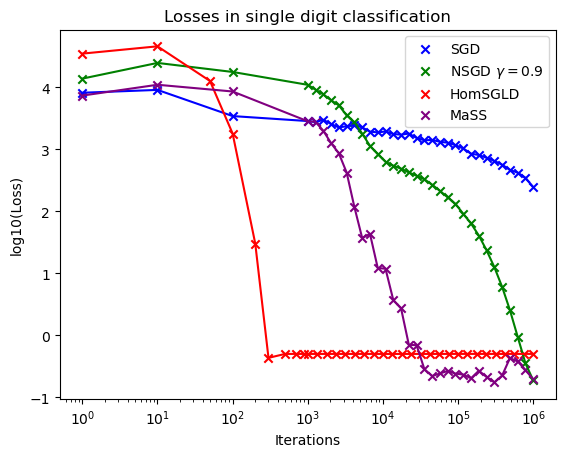

In [288]:
#plot SGD losses vs Nesterov accelerated SGD losses
indices = [1, 10, 100] + list((10**np.linspace(3, 6, 30)).astype(int))
indices_hom = [1, 10, 50, 100, 200, 300, 500, 700, 900] + list((10**np.linspace(3, 6, 25)).astype(int))

fig, ax = plt.subplots()
ax.plot(indices, np.log10(risk_SGD), c = 'b')
ax.plot(indices, np.log10(risk_NSGD), c = 'g')
ax.plot(indices_hom, np.log10(risk_HomSGLD), c = 'r')
ax.plot(indices, np.log10(risk_Mass), c = 'purple')
ax.scatter(indices, np.log10(risk_SGD), marker = 'x', c = 'b', label = 'SGD')
ax.scatter(indices, np.log10(risk_NSGD), marker = 'x', c = 'g', label = 'NSGD $\gamma = 0.9$')
ax.scatter(indices_hom, np.log10(risk_HomSGLD), marker = 'x', c = 'r', label = 'HomSGLD')
ax.scatter(indices, np.log10(risk_Mass), marker = 'x', c = 'purple', label = 'MaSS')

plt.savefig('/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/Spiliopoulos2019-SGD-algos-single-digit classification.png')

ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('log10(Loss)')
ax.set_title('Losses in single digit classification')
ax.legend()
plt.savefig('/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/Spiliopoulos2019-SGD-algos-single-digit classification.png')
plt.show()

In [218]:
def neural_net_params(x_train, y_train, x_test, y_test, Epochs = 1e6, N = 100, learning_rate = 1e-2):
    """
    Train a neural network with a specified number of units (N) using stochastic gradient descent.

    Parameters:
    x_train (np.ndarray): Training input data with shape (M, d).
    y_train (np.ndarray): Training target data with shape (M, 1).
    x_test (np.ndarray): Testing input data with shape (M_test, d).
    y_test (np.ndarray): Testing target data with shape (M_test, 1).
    N (int): The number of neural network units (default is 100).
    learning_rate (float): The learning rate for stochastic gradient descent (default is 1e-2).

    Returns:
    tuple: A tuple containing the trained coefficients 'c' and weights 'w', flattened coefficients 'c_flat',
           and a list of loss values during training.
    """
    losses = []
    #Initialise Params
    M,d = x_train.shape
    var_w = 6. / (d+N)
    var_c = 6./ (10+N)
    w =  np.random.uniform(-1, 1, (N,d))#np.random.multivariate_normal([0]*d, np.diag([np.sqrt(var_w)]*d), N).reshape(N,d)
    c =  np.random.uniform(-1000, 1000, (1,N))
    params = 0
    #sgd - update weights (using KL loss)
    epoch = 1
    Flag = 1
    
    while Flag == 1:
        #shuffle training data
        indices = np.arange(y_train.size)
        np.random.shuffle(indices)
        x_train = x_train[indices,:]
        y_train = y_train[indices]
        
        for x,y in tqdm(zip(x_train,y_train)):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            f = neural_net(x,w,c).reshape(1,-1)
            s = vsigmoid(w@x.T)
            dw = 1/N * ((f-y)@c).T*(s*(1-s))*x
            dc = 1/N * (f-y).T*s.reshape(1,-1)
            w -= learning_rate*dw
            c -= learning_rate*dc
            
            if epoch > Epochs:
                Flag = 0
                break

            epoch += 1 
            
    params = np.linalg.norm(np.hstack((c.T, w)), axis = 1).reshape(N,1)
    return c.flatten(), w.flatten(), params.flatten()

(array([5.77322062e-06, 8.65983092e-06, 2.59794928e-05, 6.63920371e-05,
        6.63920371e-05, 1.06804581e-04, 1.27010854e-04, 2.42475266e-04,
        4.30104936e-04, 6.58147150e-04, 8.48663431e-04, 9.64127843e-04,
        1.12289141e-03, 1.26144870e-03, 1.20371650e-03, 1.24124243e-03,
        1.16041734e-03, 1.11423158e-03, 9.64127843e-04, 9.03509026e-04,
        7.33199018e-04, 4.84950532e-04, 2.42475266e-04, 1.38557295e-04,
        1.27010854e-04, 6.92786474e-05, 5.19589855e-05, 3.75259340e-05,
        2.02062722e-05, 5.77322062e-06]),
 array([-1044.61151111,  -975.32609373,  -906.04067635,  -836.75525897,
         -767.46984158,  -698.1844242 ,  -628.89900682,  -559.61358944,
         -490.32817206,  -421.04275467,  -351.75733729,  -282.47191991,
         -213.18650253,  -143.90108515,   -74.61566776,    -5.33025038,
           63.955167  ,   133.24058438,   202.52600176,   271.81141915,
          341.09683653,   410.38225391,   479.66767129,   548.95308867,
          618.23850606

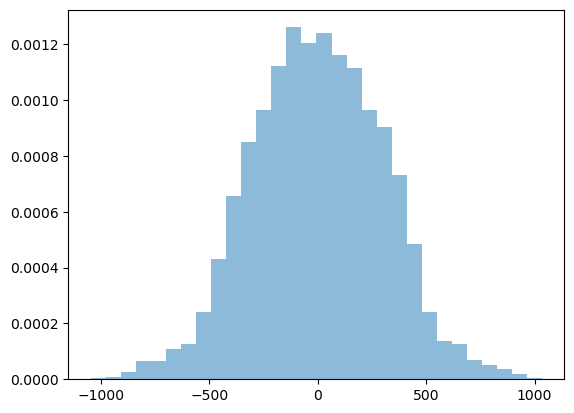

In [229]:
plt.hist(A, label = 'N: $10^3$', bins = 30, alpha = 0.5, density = True)

In [240]:
#c_1, w_1, params_1 = neural_net_params(x_train, y_train, x_test, y_test, Epochs = 1e1, N = 10, learning_rate = 1e3)
c_2, w_2, params_2 = neural_net_params(x_train, y_train, x_test, y_test, Epochs = 5e2, N = 500, learning_rate = 1e3)
c_3, w_3, params_3 = neural_net_params(x_train, y_train, x_test, y_test, Epochs = 1e3, N = 1000, learning_rate = 1e3)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [226]:
A, B, C = neural_net_params(x_train, y_train, x_test, y_test, Epochs = 5e3, N = 5000, learning_rate = 1e3)

0it [00:00, ?it/s]

In [244]:
c_4, w_4, params_4 = neural_net_params(x_train, y_train, x_test, y_test, Epochs = 1e4, N = int(1*1e4), learning_rate = 1e3)

0it [00:00, ?it/s]

In [257]:
c_5, w_5, params_5 = neural_net_params(x_train, y_train, x_test, y_test, Epochs = 5e4, N = int(5*1e4), learning_rate = 1e3)

0it [00:00, ?it/s]

KeyboardInterrupt: 

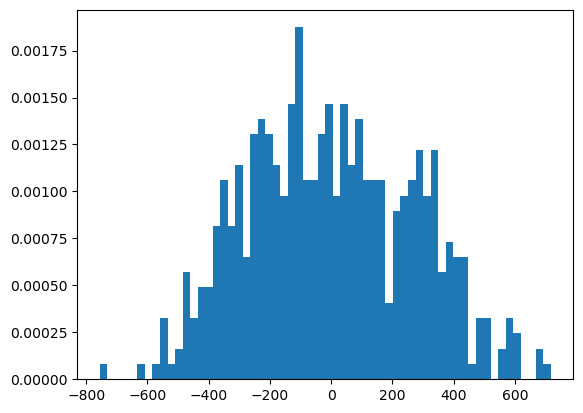

In [260]:
plt.hist(c_2, label = 'N: $10^2$', bins = 60, density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-100.png")

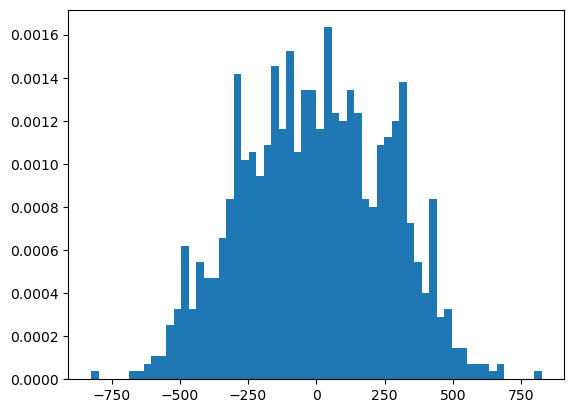

In [262]:
plt.hist(c_3, label = 'N: $10^3$', bins = 60, density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-1000.png")

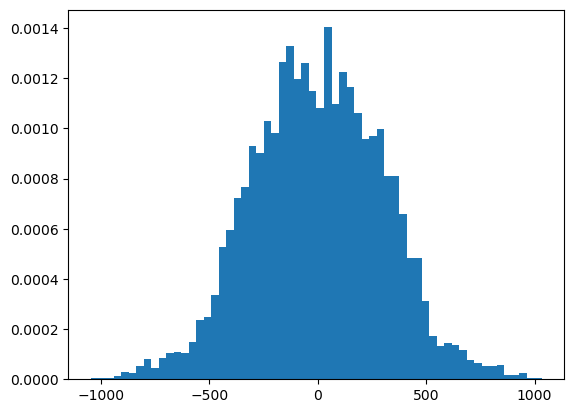

In [263]:
plt.hist(A, label = 'N: $5\cdot 10^3$', bins = 60,  density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-5000.png")

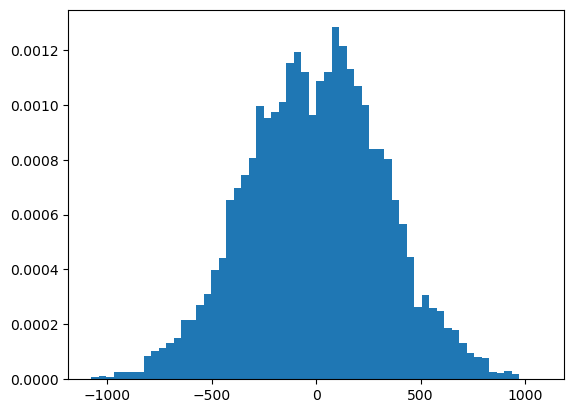

In [268]:
plt.hist(c_4, label = 'N: $1\cdot 10^4$', bins = 60, density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-10000.png")

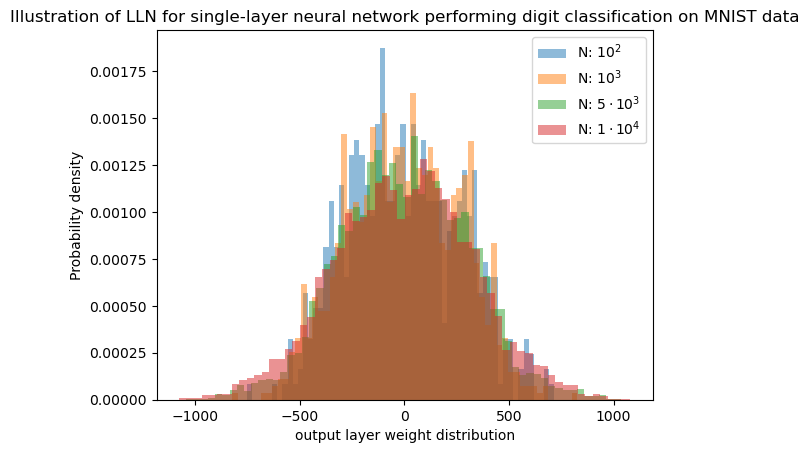

In [259]:
plt.hist(c_2, label = 'N: $10^2$', bins = 60, density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-100.png")

plt.hist(c_3, label = 'N: $10^3$', bins = 60, alpha = 0.5, density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-1000.png")

plt.hist(A, label = 'N: $5\cdot 10^3$', bins = 60, alpha = 0.5, density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-5000.png")

plt.hist(c_4, label = 'N: $1\cdot 10^4$', bins = 60, alpha = 0.5, density = True)
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/MNIST-hist-N-10000.png")


plt.title('Illustration of LLN for single-layer neural network performing digit classification on MNIST data')
plt.ylabel('Probability density')
plt.xlabel('output layer weight distribution')
plt.legend()

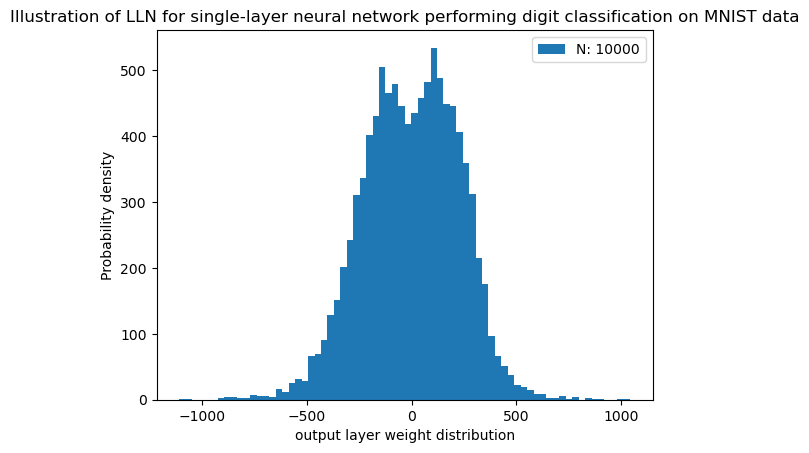

In [43]:
plt.hist(params, label = 'N: $10^4$', bins = 70)
plt.title('Illustration of LLN for single-layer neural network performing digit classification on MNIST data')
plt.ylabel('Probability density')
plt.xlabel('output layer weight distribution')
plt.legend()

## General Observations

- Nesterov acceleration beat plain SGD, but was beaten by MF-HomSGLD, which plateaued early but achieved a substantially smaller loss in the same amount of time
- MF-HomSGLD (in the paper by Pavliotis, Kantas and Parpas entitled 'The sharp, the flat and the shallow: Can weakly interacting agents learn to escape bad minima?') matches the performance of plain SGD. Still, it gets stuck for more significant iterations and plateaus. However, in the MNIST one-digit classification, the algorithm attains a substantially smaller loss, about two orders of magnitude less than the other algorithms. However, it suffers from plateauing early again.
- Finally, the single-digit classifier with the architecture satisfied the assumptions made in the paper. It was able to reproduce the distribution of parameters in the paper, as seen in the plot above, capturing the bimodality of the network parameter distribution in the paper.